[itsandrewgao](https://twitter.com/itsandrewgao) my very rushed and shitty attempt at implementing just the mLSTM to predict sine waves

<a target="_blank" href="https://colab.research.google.com/github/andrewgcodes/xlstm/blob/main/mLSTM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

def generate_sine_wave(seq_len, num_sequences):
    x = np.linspace(0, 2 * np.pi, seq_len)
    y = np.sin(x)
    return torch.tensor(y).float().view(-1, 1).repeat(1, num_sequences).unsqueeze(0)



class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM components
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))  # Input gate bias

        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))  

        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        self.bc = nn.Parameter(torch.zeros(hidden_size))  

        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))  

    def forward(self, x, states):
        c, h = states[0], states[1]

        it = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.bi)  # Input gate
        ft = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.bf)  # Forget gate
        ot = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.bo)  # Output gate
        zt = torch.tanh(self.Wxc(x) + self.Whc(h) + self.bc)  # New candidate cell state

        ct = ft * c + it * zt  # Update cell state
        ht = ot * torch.tanh(ct)  # Hidden state (also output)

        return ct, ht

    def init_hidden(self):
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))




In [4]:
input_size = 1
hidden_size = 10
mem_dim = 10
seq_len = 100
num_sequences = 1

model = LSTM(input_size, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

data = generate_sine_wave(seq_len, num_sequences)
print("data",data.shape)
states = model.init_hidden()

for epoch in range(300):
    
    optimizer.zero_grad()
    loss = 0
    for t in range(seq_len - 1):
        x = data[:, t]
        y_true = data[:, t + 1]
        ht, ct = model(x, states)
        y_pred, states = ht, (ct, ht)
        loss += criterion(y_pred, y_true)
        
    states = (states[0].detach(), states[1].detach())
    
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch} Loss {loss.item()}')

test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):

    x = data[:, t]
    ht, ct = model(x, states)
    y_pred, states = ht, (ct, ht)
    test_output.append(y_pred.detach().numpy().ravel()[0])



data torch.Size([1, 100, 1])
Epoch 0 Loss 62.88545608520508
Epoch 100 Loss 3.053042411804199
Epoch 200 Loss 0.37752580642700195


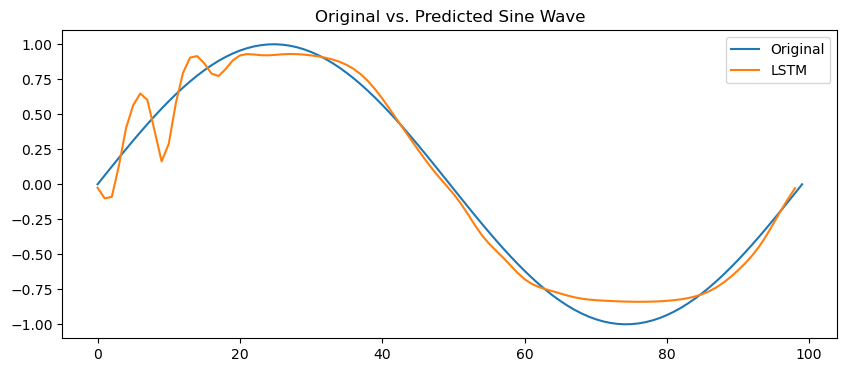

In [6]:
test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    ht, ct = model(x, states)
    y_pred, states = ht, (ct, ht)
    test_output.append(y_pred.detach().numpy().ravel()[0])

plt.figure(figsize=(10, 4))
plt.title('Original vs. Predicted Sine Wave')
plt.plot(data.numpy().ravel(), label='Original')
plt.plot(test_output, label='LSTM')

plt.legend()
plt.show()

In [7]:
with open('lstm_results_biais.npy', 'wb') as f:
    np.save(f, test_output)